# Import

In [1]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
# 한글 폰트가 깨지면 실행하세요! 
import matplotlib.font_manager as fm
fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
fontlist[:]

from matplotlib import font_manager, rc
font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
#font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 1. Data Load  

**치매 예방을 위한 라이프로그 치매 분류**

**9,327 rows × 66 columns**

For more details https://aihub.or.kr/problem_contest/nipa-learning-platform/6

In [36]:
path = "./Dataset/원천데이터/1.걸음거리/"
activity = pd.read_csv(path + "sample_activity.csv")

path = "./Dataset/원천데이터/2.수면/"
sleep = pd.read_csv(path + "sample_sleep.csv")

path = "./Dataset/원천데이터/3.인지기능/"
mmse = pd.read_csv(path + "sample_mmse.csv")

path = "./Dataset/"

# original data : data 
# original label data : data_label 
data =  pd.read_csv(path + "train.csv")
data_label =  pd.read_csv(path + "train_label.csv")

In [37]:
# data + data_label 
# data['DIAG_NM'] = data_label

label_dict =  dict([(i,a) for i,a in zip(data_label['SAMPLE_EMAIL'], data_label['DIAG_NM'])])

# DIAG_NM
data['DIAG_NM'] = data['EMAIL'].map(label_dict)
data

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,...,3863,3,735,2,...,-0.16,99.99,NaN,\r,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,...,4411,1,780,4,...,-0.09,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,...,11057,1,518,1,...,0.41,99.99,NaN,\r,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,...,5135,4,578,0,...,0.27,99.99,NaN,\r,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


# 2. EDA  

**9,327 rows × 66 columns**

148명에 대한 데일리 라이프로그 데이터 
크게 걸음거리, 수면, 컨버팅 데이터로 나눌 수 있겠습니다. 

**basic**
- timezone 시간 장소 정보 
    - drop 
    - 완벽한 null variable 
- EMAIL
    - drop
    - 식별자 feature 
- summary_date

**activity**
- activity_class_5min, activity_met_1min, 하루간 5분당 활동 로그,하루간 1분당 MET 로그
    - drop 
    - BLOB type -> js로 읽을 수 있다고는 함 

**sleep**
- sleep_is_longest, 본 수면 여부 
    - 전부 다 1 
- sleep_temperature_trend_deviation, 피부 온도 경향 편차 
    - 전부 다 99.99
- sleep_total, 수면 시간 
    - 전부 다 \r
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
- 5분 당 심박동로그, 수면 상태 로그, 5분당 심박동변동 로그
    - drop 
    - BLOB type 

**converting**
- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    
So we may use 56 columns for training...

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   EMAIL                                     9327 non-null   object 
 1   summary_date                              9327 non-null   object 
 2   activity_average_met                      9327 non-null   float64
 3   activity_cal_active                       9327 non-null   int64  
 4   activity_cal_total                        9327 non-null   int64  
 5   activity_class_5min                       9327 non-null   object 
 6   activity_daily_movement                   9327 non-null   int64  
 7   activity_high                             9327 non-null   int64  
 8   activity_inactive                         9327 non-null   int64  
 9   activity_inactivity_alerts                9327 non-null   int64  
 10  activity_low                        

<AxesSubplot:>

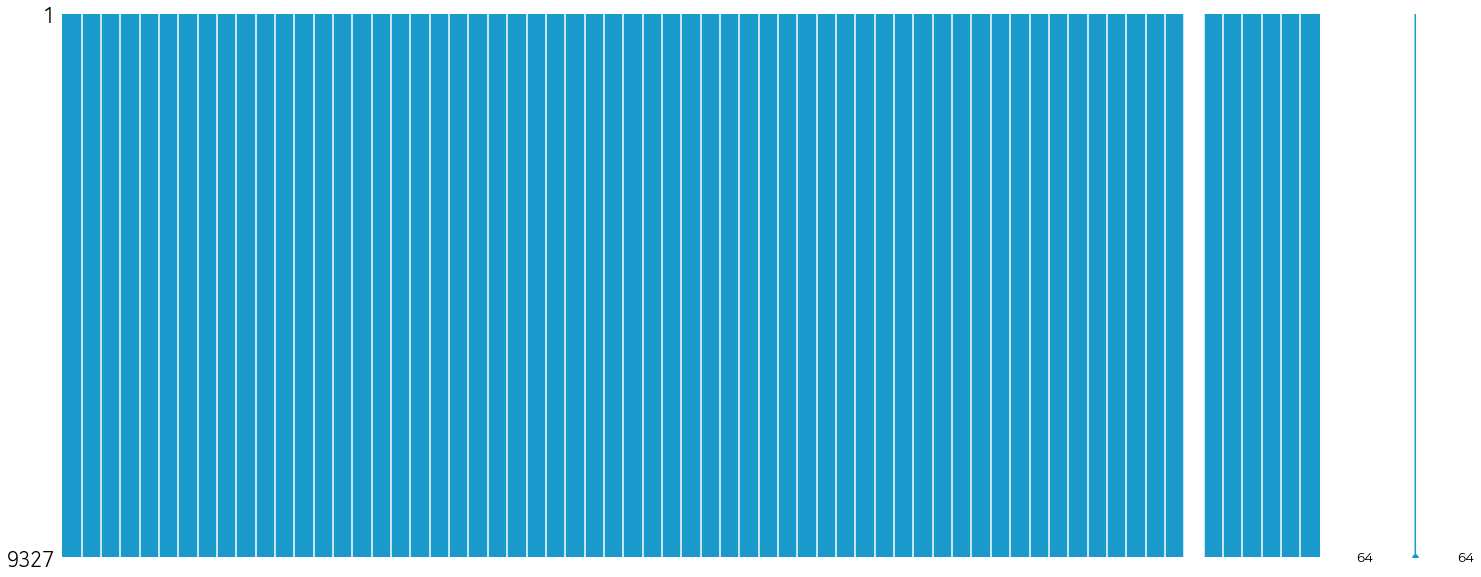

In [9]:
# check missing values 
# 'timezone'
msno.matrix(data.iloc[:, :], color=(0.1, 0.6, 0.8))

### activity data

In [55]:
data_activity = data.iloc[:, 2:28].copy()
data_activity.head()

,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,...,activity_rest,activity_score,activity_score_meet_daily_targets,activity_score_move_every_hour,activity_score_recovery_time,activity_score_stay_active,activity_score_training_frequency,activity_score_training_volume,activity_steps,activity_total
0,1.71875,730,2944,...,14346,0,417,0,545,47,...,399,96,95,100,100,86,100,98,15867,592
1,1.40625,342,2449,...,6352,0,473,0,392,8,...,538,91,78,100,100,83,100,97,7755,400
2,1.46875,401,2544,...,7297,0,586,0,362,24,...,459,93,95,100,100,71,96,96,8341,386
3,0.34375,27,1850,...,491,0,176,0,34,1,...,1210,93,95,100,100,74,96,92,8122,35
4,1.46875,333,2518,...,5861,0,646,0,377,6,...,392,88,95,100,100,65,71,80,7378,383


In [49]:
data_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   activity_average_met               9327 non-null   float64
 1   activity_cal_active                9327 non-null   int64  
 2   activity_cal_total                 9327 non-null   int64  
 3   activity_class_5min                9327 non-null   object 
 4   activity_daily_movement            9327 non-null   int64  
 5   activity_high                      9327 non-null   int64  
 6   activity_inactive                  9327 non-null   int64  
 7   activity_inactivity_alerts         9327 non-null   int64  
 8   activity_low                       9327 non-null   int64  
 9   activity_medium                    9327 non-null   int64  
 10  activity_met_1min                  9327 non-null   object 
 11  activity_met_min_high              9327 non-null   int64

In [50]:
# check objec type의 변수들 
# 하루간 5분당 활동 로그 BLOB 
# 하루간 1분당 MET 로그 BLOB
print(data_activity['activity_met_1min'].value_counts())
print(data_activity['activity_class_5min'].value_counts())

...    9327
Name: activity_met_1min, dtype: int64
...    9327
Name: activity_class_5min, dtype: int64


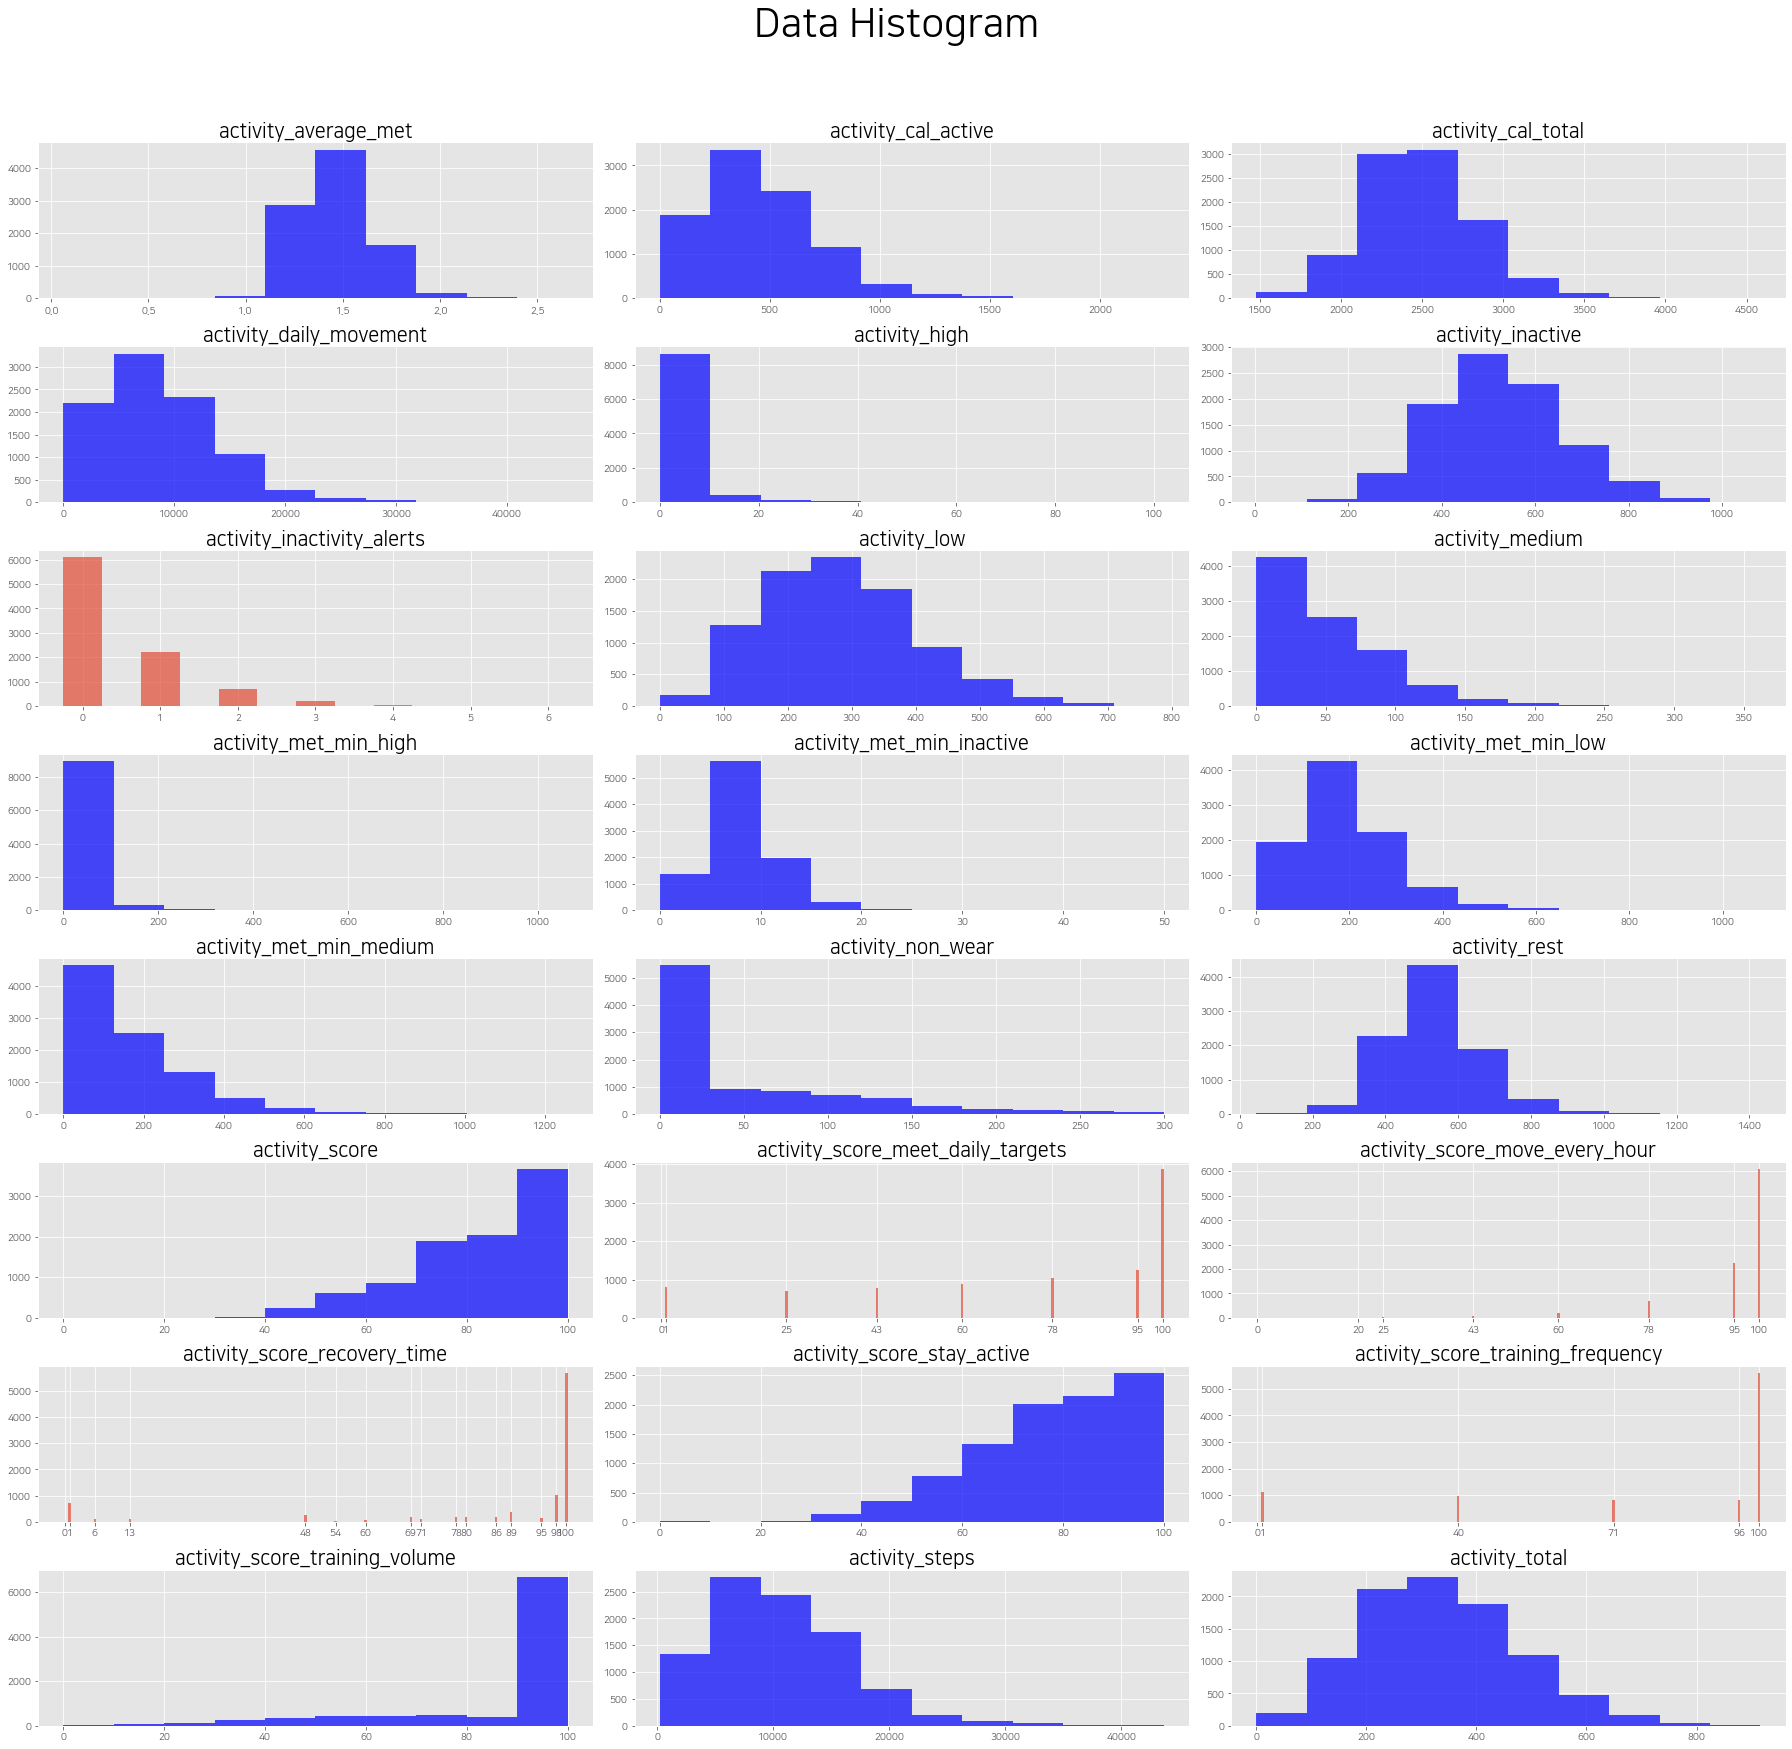

In [54]:
data_activity = data_activity.drop(['activity_met_1min', 'activity_class_5min'], axis=1)

plt.style.use("ggplot")

# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(25,25))
plt.suptitle("Data Histogram", fontsize=40)

cols = data_activity.columns
for i in range(len(cols)):
    plt.subplot(8,3,i+1)
    plt.title(cols[i], fontsize=20)
    if len(data_activity[cols[i]].unique()) > 20:
        plt.hist(data_activity[cols[i]], color='b', alpha=0.7)
    else:
        temp = data_activity[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.show()

### sleep data

In [64]:
data_sleep = data.iloc[:, 28:58].copy()
data_sleep.head()

,sleep_awake,sleep_breath_average,sleep_deep,sleep_duration,sleep_efficiency,sleep_hr_5min,sleep_hr_average,sleep_hr_lowest,sleep_hypnogram_5min,sleep_is_longest,...,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,sleep_temperature_deviation,sleep_temperature_trend_deviation
0,13950,16.500,2100,35460,61,...,70.53,62,...,1,...,100,41,50,27,97,66,62,-0.12,-0.12,99.99
1,7680,17.375,2430,24720,69,...,68.01,63,...,1,...,100,49,43,46,91,35,44,-0.32,-0.32,99.99
2,11880,17.000,2820,33240,64,...,64.89,59,...,1,...,100,56,47,34,89,41,62,0.07,0.07,99.99
3,9600,17.250,1770,29700,68,...,63.70,57,...,1,...,100,35,40,44,86,29,56,-0.41,-0.41,99.99
4,10710,17.250,3150,31440,66,...,67.07,60,...,1,...,100,64,55,39,14,54,59,-0.27,-0.27,99.99


In [76]:
# sleep_total 
# 수면 시간 
data['sleep_total'].value_counts()

\r    9327
Name: sleep_total, dtype: int64

In [65]:
data_sleep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   sleep_awake                        9327 non-null   int64  
 1   sleep_breath_average               9327 non-null   float64
 2   sleep_deep                         9327 non-null   int64  
 3   sleep_duration                     9327 non-null   int64  
 4   sleep_efficiency                   9327 non-null   int64  
 5   sleep_hr_5min                      9327 non-null   object 
 6   sleep_hr_average                   9327 non-null   float64
 7   sleep_hr_lowest                    9327 non-null   int64  
 8   sleep_hypnogram_5min               9327 non-null   object 
 9   sleep_is_longest                   9327 non-null   int64  
 10  sleep_light                        9327 non-null   int64  
 11  sleep_midpoint_at_delta            9327 non-null   int64

In [66]:
# check objec type의 변수들 
# 하루간 5분당 활동 로그 BLOB 
# 하루간 1분당 MET 로그 BLOB
print(data_sleep['sleep_hr_5min'].value_counts())
print(data_sleep['sleep_rmssd_5min'].value_counts())
print(data_sleep['sleep_hypnogram_5min'].value_counts())

...    9327
Name: sleep_hr_5min, dtype: int64
...    9327
Name: sleep_rmssd_5min, dtype: int64
...    9327
Name: sleep_hypnogram_5min, dtype: int64


C:\Users\mtang\AppData\Local\Temp\ipykernel_44288\1006144916.py:19: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout(rect=[0, 0.01, 1, 0.95])
C:\Users\mtang\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


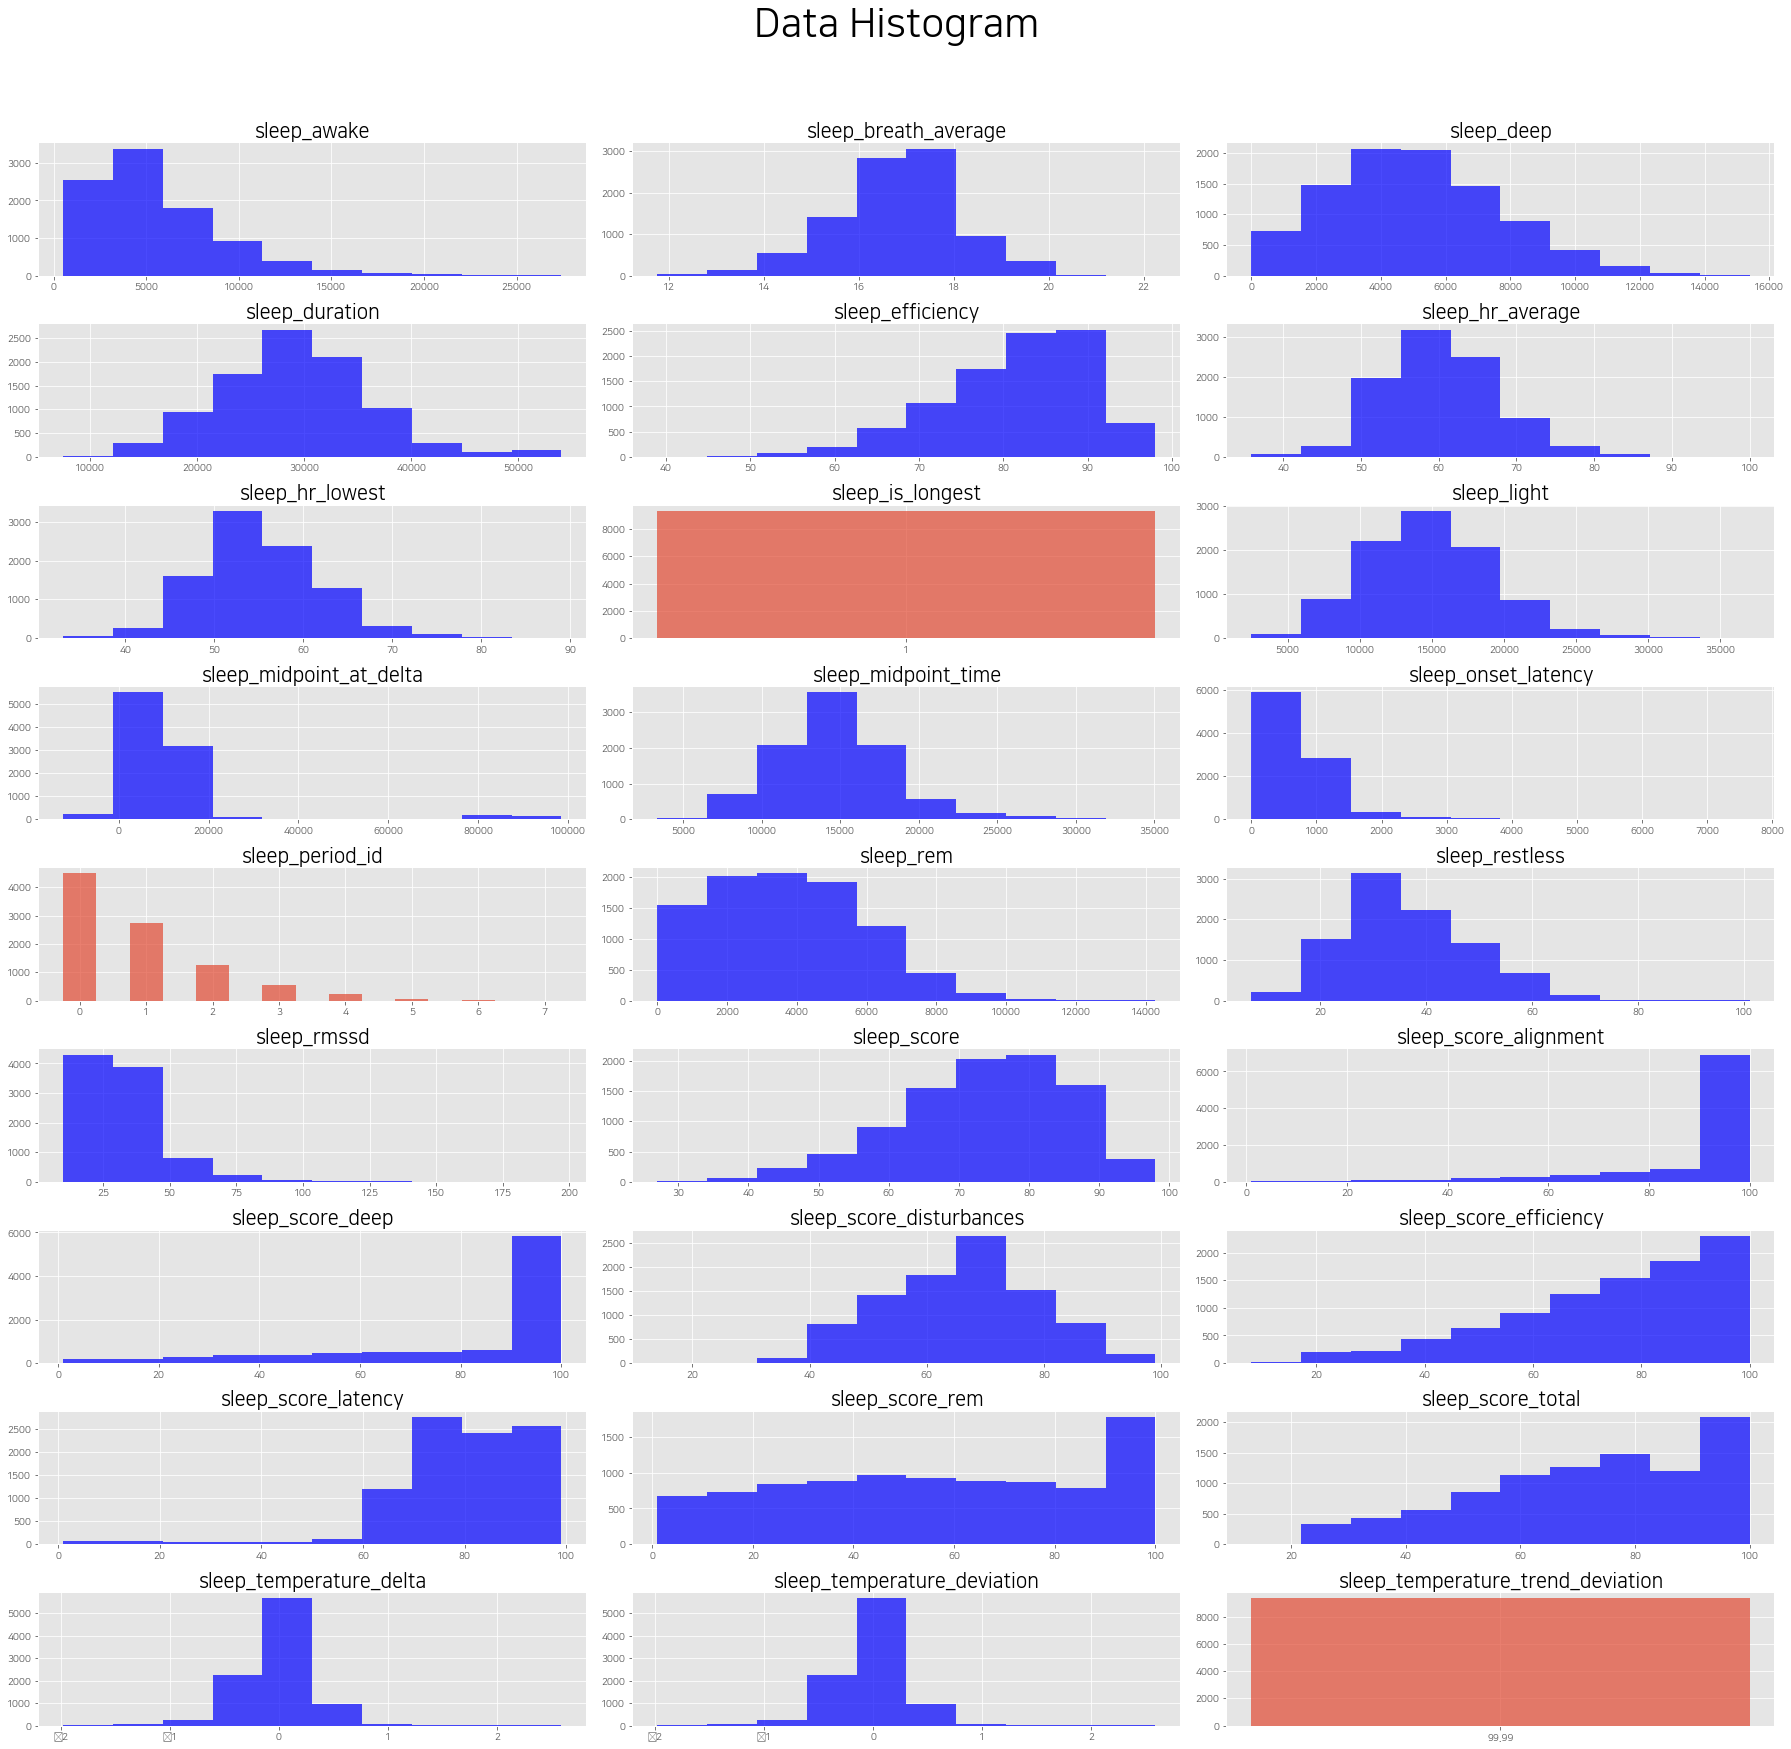

In [61]:
#data_sleep = data_sleep.drop(['sleep_hr_5min', 'sleep_rmssd_5min', 'sleep_hypnogram_5min'], axis=1)

plt.style.use("ggplot")

# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(25,25))
plt.suptitle("Data Histogram", fontsize=40)

cols = data_sleep.columns
for i in range(len(cols)):
    plt.subplot(9,3,i+1)
    plt.title(cols[i], fontsize=20)
    if len(data_sleep[cols[i]].unique()) > 20:
        plt.hist(data_sleep[cols[i]], color='b', alpha=0.7)
    else:
        temp = data_sleep[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.show()

### convert data 

In [43]:
data_convert = data.iloc[:, 60:65].copy()
data_convert

,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8)
0,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...
1,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...
2,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...
3,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...
4,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...
...,...,...,...,...,...
9322,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...
9323,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...
9324,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...
9325,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...


In [111]:
def graph(x, y) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = str(x))
    plt.plot(pred, label = str(y))
    plt.legend()
    plt.show()

signal_list = list(data_convert['CONVERT(activity_class_5min USING utf8)'].str.split('/'))
signal_df = pd.DataFrame(signal_list)
signal_df = signal_df.astype('float64')
signal_df.dtypes

ValueError: could not convert string to float: ''

**y variable**

# 3. Preprocessing 

**9,327 rows × 66 columns**

**9,327 rows × 51 columns**


**feature drop**
- timezone
- EMAIL
- activity_class_5min, activity_met_1min
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
- sleep_temperature_trend_deviation, sleep_is_longest, sleep_total
- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    
So we may use 56 columns for training...

In [80]:
processed_data = data.drop(['timezone', 'EMAIL',
                            'activity_class_5min', 'activity_met_1min',
                            'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min',
                            'sleep_is_longest', 'sleep_temperature_trend_deviation', 'sleep_total'], axis=1).copy()

convert_col = processed_data.iloc[:, 50:55].columns
processed_data = processed_data.drop(convert_col, axis=1)
processed_data

,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,...,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,sleep_temperature_deviation,DIAG_NM
0,2020-11-27,1.71875,730,2944,14346,0,417,0,545,47,...,100,41,50,27,97,66,62,-0.12,-0.12,CN
1,2020-11-28,1.40625,342,2449,6352,0,473,0,392,8,...,100,49,43,46,91,35,44,-0.32,-0.32,CN
2,2020-11-29,1.46875,401,2544,7297,0,586,0,362,24,...,100,56,47,34,89,41,62,0.07,0.07,CN
3,2020-11-30,0.34375,27,1850,491,0,176,0,34,1,...,100,35,40,44,86,29,56,-0.41,-0.41,CN
4,2020-12-01,1.46875,333,2518,5861,0,646,0,377,6,...,100,64,55,39,14,54,59,-0.27,-0.27,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,2020-12-22,1.34375,227,2316,3863,3,735,2,155,17,...,100,53,46,74,97,84,82,-0.16,-0.16,CN
9323,2020-12-24,1.34375,249,2351,4411,1,780,4,167,22,...,100,34,57,76,81,95,86,-0.09,-0.09,CN
9324,2020-12-26,1.53125,570,2682,11057,1,518,1,332,61,...,100,1,56,69,86,89,64,0.41,0.41,CN
9325,2020-12-27,1.34375,295,2331,5135,4,578,0,173,30,...,100,9,59,86,89,98,97,0.27,0.27,CN


In [81]:
processed_data.columns

Index(['summary_date', 'activity_average_met', 'activity_cal_active',
       'activity_cal_total', 'activity_daily_movement', 'activity_high',
       'activity_inactive', 'activity_inactivity_alerts', 'activity_low',
       'activity_medium', 'activity_met_min_high', 'activity_met_min_inactive',
       'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear',
       'activity_rest', 'activity_score', 'activity_score_meet_daily_targets',
       'activity_score_move_every_hour', 'activity_score_recovery_time',
       'activity_score_stay_active', 'activity_score_training_frequency',
       'activity_score_training_volume', 'activity_steps', 'activity_total',
       'sleep_awake', 'sleep_breath_average', 'sleep_deep', 'sleep_duration',
       'sleep_efficiency', 'sleep_hr_average', 'sleep_hr_lowest',
       'sleep_light', 'sleep_midpoint_at_delta', 'sleep_midpoint_time',
       'sleep_onset_latency', 'sleep_period_id', 'sleep_rem', 'sleep_restless',
       'sleep_rmssd', 'sl